In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import h5py

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
ID_COL = 'SeriesInstanceUID'

LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

# All tags (other than PixelData and SeriesInstanceUID) that may be in a test set dcm file
DICOM_TAG_ALLOWLIST = [
    'BitsAllocated',
    'BitsStored',
    'Columns',
    'FrameOfReferenceUID',
    'HighBit',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'Modality',
    'PatientID',
    'PhotometricInterpretation',
    'PixelRepresentation',
    'PixelSpacing',
    'PlanarConfiguration',
    'RescaleIntercept',
    'RescaleSlope',
    'RescaleType',
    'Rows',
    'SOPClassUID',
    'SOPInstanceUID',
    'SamplesPerPixel',
    'SliceThickness',
    'SpacingBetweenSlices',
    'StudyInstanceUID',
    'TransferSyntaxUID',
]

In [3]:
class MiniVolDataset(Dataset):
    """
    One shard -> many mini-volumes (32, 256, 256)
    
    For each subject s with Z_s slices:
      - Start with avail = [0, 1, ..., Z_s-1] (already ordered from preprocessing)
      - While len(avail) >= K:
          * pick K quantile positions across avail (no replacement)
          * form a block of length K using those indices (sorted)
          * remove them from avail
      - Any leftover < K slices are discarded.

    So every slice for a subject is used at most once and
    slices inside each mini-volume are in ascending z-order
    """

    def __init__(self, h5_path, K=32, use_3d=True, return_id=False):
        self.h5_path = h5_path
        self.K = K
        self.use_3d = use_3d
        self.return_id = return_id
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        mini_index = [] # list of (subject_idx, slice_idx_array)

        with h5py.File(h5_path, "r") as f:
            z_len = f["z_len"][:] # (num_subjects,)
            num_scans = len(z_len)

            for s in range(num_scans):
                Z = int(z_len[s])
                if Z < K:
                    continue # this subject contributes no mini-vols

                # all slice indices in physical order (from preprocessing)
                avail = np.arange(Z, dtype=np.int16)

                # repeatedly carve out K indices spread across 'avail'
                while len(avail) >= K:
                    n = len(avail) # current number of remaining slices

                    # positions in 0..n-1 roughly at quantiles:
                    # floor((i+0.5) * n / K), i = 0,...,K-1
                    # this gives K distinct, increasing integers when n >= K
                    pos = np.floor((np.arange(K) + 0.5) * n / K).astype(int)

                    # get actual slice indices (already sorted because avail and pos are sorted)
                    block = avail[pos] # shape (K,)

                    # record this mini-volume definition
                    mini_index.append((s, block.copy()))

                    # remove those positions from 'avail' so they won't be reused
                    avail = np.delete(avail, pos)

        self.mini_index = mini_index

        # HDF5 handles opened lazily per worker
        self._file = None
        self._x_grp = None
        self._y_ds = None
        self._uid_ds = None

    def _ensure_open(self): # allows us to open file once per shard (so we don't need to reopen each time we index the dataset)
        if self._file is None:
            self._file = h5py.File(self.h5_path, "r")
            self._x_grp = self._file["x"]
            self._y_ds  = self._file["y"]
            self._uid_ds = self._file.get("uid", None)

    def __len__(self):
        return len(self.mini_index)

    def __getitem__(self, idx):
        self._ensure_open()

        subj_idx, slice_idx = self.mini_index[idx]  # slice_idx: (K,)

        # load ONLY the K slices we need; underlying dataset is ordered
        dset = self._x_grp[str(subj_idx)] # shape (Z_s, 256, 256)
        mini = dset[slice_idx] # shape (K, 256, 256), float16
        
        x = torch.from_numpy(mini)
        x = self.pool(x) # max pool to drop dimensions to (K, 128, 128)
        
        if self.use_3d:
            # (1, K, H, W) for 3D convs
            x = x.unsqueeze(0)
        x = x.float()
        
        # labels: one per subject
        y_np = self._y_ds[subj_idx]
        y = torch.from_numpy(y_np.astype("int64"))

        if self.return_id:
            return x, y, int(subj_idx)
        else:
            return x, y

In [4]:
shard_dirs = [
    "preprocess-cnn-all-slices-shard-1",
    "preprocess-cnn-all-slices-shard-2",
    "preprocess-cnn-all-slices-shard-3",
    "preprocess-cnn-all-slices-shard-4",
]
shard_paths = [f"/kaggle/input/{d}/dataset_shard_{i}_all_slices.h5" for i, d in enumerate(shard_dirs)]

per_shard_ds = [
    MiniVolDataset(
        h5_path=path,
        K=32,
        use_3d=True, # channel dim specified 
        return_id=True, # gives subject index within that shard
    )
    for path in shard_paths
]

full_dataset = ConcatDataset(per_shard_ds)

In [5]:
# Subject-level train/val split PER SHARD
rng = np.random.default_rng(42)

train_subsets = []
val_subsets   = []
test_subsets  = []

for shard_id, ds in enumerate(per_shard_ds):
    # all subject indices for this shard
    subj_indices = np.array([s for (s, _) in ds.mini_index], dtype=int)
    unique_subj  = np.unique(subj_indices)

    print(f"Shard {shard_id}: {len(unique_subj)} subjects, {len(ds)} mini-volumes")

    # shuffle subjects and split 70/10/20 (per shard)
    rng.shuffle(unique_subj)
    n_subj = len(unique_subj)
    n_train_subj = int(0.7 * n_subj)
    n_val_subj = int(0.1 * n_subj)

    train_subj = set(unique_subj[:n_train_subj])
    val_subj   = set(unique_subj[n_train_subj:(n_train_subj + n_val_subj)])
    test_subj   = set(unique_subj[(n_train_subj + n_val_subj):])

    # dataset indices whose subject is in train vs val
    train_idx = [i for i, (s, _) in enumerate(ds.mini_index) if s in train_subj]
    val_idx   = [i for i, (s, _) in enumerate(ds.mini_index) if s in val_subj]
    test_idx   = [i for i, (s, _) in enumerate(ds.mini_index) if s in test_subj]

    print(
        f"  -> train mini-vols: {len(train_idx)}, "
        f"val mini-vols: {len(val_idx)}, "
        f"test mini-vols: {len(test_idx)}"
    )

    train_subsets.append(Subset(ds, train_idx))
    val_subsets.append(Subset(ds, val_idx))
    test_subsets.append(Subset(ds, test_idx))

# final cross-shard train/val datasets
train_dataset = ConcatDataset(train_subsets)
val_dataset   = ConcatDataset(val_subsets)
test_dataset   = ConcatDataset(test_subsets)

print("Total train mini-vols:", len(train_dataset))
print("Total val mini-vols:", len(val_dataset))
print("Total test mini-vols:", len(test_dataset))

Shard 0: 788 subjects, 6626 mini-volumes
  -> train mini-vols: 4597, val mini-vols: 659, test mini-vols: 1370
Shard 1: 750 subjects, 6190 mini-volumes
  -> train mini-vols: 4279, val mini-vols: 634, test mini-vols: 1277
Shard 2: 765 subjects, 6389 mini-volumes
  -> train mini-vols: 4643, val mini-vols: 562, test mini-vols: 1184
Shard 3: 765 subjects, 6400 mini-volumes
  -> train mini-vols: 4510, val mini-vols: 633, test mini-vols: 1257
Total train mini-vols: 18029
Total val mini-vols: 2488
Total test mini-vols: 5088


In [6]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4, # allows for parallelism on the CPU data loading side
    pin_memory=True, #makes it faster to move batches from CPU to GPU (where we can run batches in parallel through model)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# check one batch
xb, yb, subj_b = next(iter(train_loader))
print("Batch x shape:", xb.shape) # (B, 1, 16, 256, 256)
print("Batch y shape:", yb.shape) # (B, 14)
print("Batch subj_idx:", subj_b[:5])

Batch x shape: torch.Size([64, 1, 32, 128, 128])
Batch y shape: torch.Size([64, 14])
Batch subj_idx: tensor([262, 717, 827,  26, 625])


# **3D CNN**

code copied from RSNA Competition - C2

In [7]:
# run a CNN with three blocks of 2 convolutional layers followed by a max pooling layer
# treat depth of slices as channels

class ConvModel(nn.Module):
    def __init__(self,lr,wd, weights):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.weights = weights
        self.net = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.01),
            nn.Conv3d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2, 2), # output: 8 x 16 x 64 x 64

            nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.01),
            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2, 2), # output: 32 x 8 x 32 x 32

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.01),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2, 2), # output: 128 x 4 x 16 x 16

            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(128, 256), # output: 256 x 1
            nn.LeakyReLU(0.01),
            nn.Dropout(0.5),
            nn.Linear(256, 128), # output: 128 x 1
            nn.LeakyReLU(0.01),
            nn.Linear(128, 14)) # 14 output layers

    def forward(self,X):
        # forward propagate x through network
        return self.net(X)

    def loss(self,logits,y,averaged=True):
        # compute multi-label classificationcross-entropy loss between network output and true labels y
        weights = torch.tensor(self.weights, dtype=logits.dtype, device=logits.device) # ensure weights are a tensor

        # numerically stable loss computation, logits = max(logits, 0) - logits * y + log(1 + exp(-abs(logits)))
        loss_per_entry = torch.clamp(logits, min = 0) - logits * y + torch.log1p(torch.exp(-torch.abs(logits))) #compute binary cross_entropy per entropy
        loss_per_entry = loss_per_entry * weights # apply weights
        return loss_per_entry.mean()

    def predict(self,X, threshold = 0.5):
        logits = self.forward(X)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()
        return preds

    def configure_optimizers(self):
        # set up the Adam optimizer with default parameters and
        # model's learning rate and weight decay
        return optim.Adam(self.parameters(), weight_decay = self.wd, lr = self.lr)

# **Train Model**

In [8]:
def train_model(model,trainloader,valloader,num_epochs):
    train_loss, val_loss = [], []
    opt = model.configure_optimizers()
    device = next(model.parameters()).device # Get the device of the model

    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        # train
        model.train()
        running_loss, n_seen = 0.0, 0
        for Xtr, ytr, subj in trainloader:
            Xtr, ytr = Xtr.to(device), ytr.to(device) # Move data to the same device as the model
            opt.zero_grad()
            yhat_logit = model.forward(Xtr)
            loss = model.loss(yhat_logit, ytr, averaged=True)  # mean over this batch
            loss.backward()
            opt.step()
            bs = ytr.size(0) # batch size
            running_loss += loss.item() * bs # just get sum for batch
            n_seen += bs
        train_loss.append(running_loss / max(1, n_seen))

        # val
        model.eval()
        v_running, v_seen = 0.0, 0
        with torch.no_grad():
            for Xval, yval, subj in valloader:
                Xval, yval = Xval.to(device), yval.to(device) # Move data to the same device as the model
                vloss = model.loss(model(Xval), yval, averaged=True)
                bs = yval.size(0)
                v_running += vloss.item() * bs
                v_seen += bs
        current_v_loss = v_running / max(1, v_seen)
        
        val_loss.append(current_v_loss)

        if current_v_loss < best_val_loss:
            best_val_loss = current_v_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_loss': current_v_loss,
            }, "best_model.pt")
            print(f" Saved new best model at epoch {epoch+1} with val_loss = {current_v_loss:.4f}")
        else:
            print(f" Completed epoch {epoch+1} with val_loss = {current_v_loss:.4f}")
        
    return model,train_loss,val_loss

In [9]:
def plot_loss_curves(num_epochs,train_loss,val_loss):
   plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
   plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
   plt.title("Training and Validation Loss Curves")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()

 Saved new best model at epoch 1 with val_loss = 0.0315
 Completed epoch 2 with val_loss = 0.0338
 Completed epoch 3 with val_loss = 0.0361
 Completed epoch 4 with val_loss = 0.0318
 Saved new best model at epoch 5 with val_loss = 0.0313


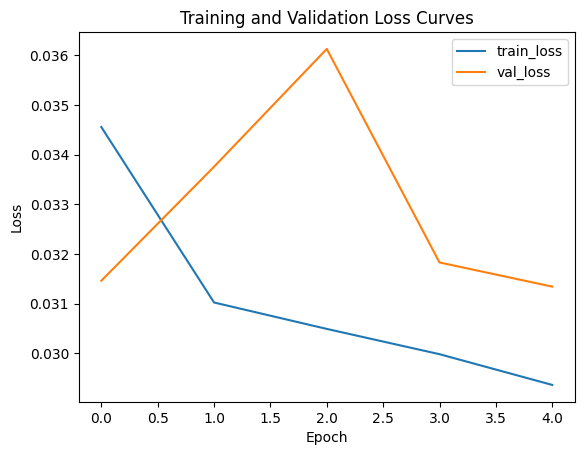

In [10]:
# set hyperparameters
lr = 1e-4
wd = 5e-4
num_epochs = 5

weights = np.array([1/26]*13 + [.5])

# define model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = ConvModel(lr, wd, weights).to(device)

# train model
cnn_model, train_loss, val_loss = train_model(cnn_model, train_loader, val_loader, num_epochs)

# plot validation and training loss curves
plot_loss_curves(num_epochs, train_loss, val_loss)

In [11]:
def model_eval(model, testloader, aneurysm_threshold = 0.5, location_threshold = 0.2):
    model.eval()
    ys, probs_list, subj_list = [], [], [] # Use a list to store batches of test data

    with torch.no_grad():
        for tX, ty, tsubj in testloader:
            tX, ty, tsubj = tX.to(device), ty.to(device), tsubj.to(device)
            
            # forward pass
            logits = model.forward(tX)
            prob = torch.sigmoid(logits)

            # Store
            ys.append(ty.detach().cpu().numpy())
            probs_list.append(prob.detach().cpu().numpy())
            subj_list.append(tsubj.cpu().numpy())
            
    ys = np.concatenate(ys, axis = 0)
    probs = np.concatenate(probs_list, axis = 0)
    subjects = np.concatenate(subj_list, axis = 0)

    # subject level aggregation
    from collections import defaultdict

    probs_by_subj = defaultdict(list)
    ys_by_subj = defaultdict(list)

    # put y, probs into subject oriented list
    for y, p, sid in zip(ys, probs, subjects):
        probs_by_subj[int(sid)].append(p)
        ys_by_subj[int(sid)].append(y)

    final_probs_subj = {}
    final_preds_subj = {}
    final_labels_subj = {}

    for sid in probs_by_subj.keys():
        subj_probs = np.stack(probs_by_subj[sid], axis = 0)
        subj_labels = np.stack(ys_by_subj[sid], axis = 0)

        final_prob_vec = np.zeros(14)
        final_pred_vec = np.zeros(14, dtype = int)
        final_label_vec = subj_labels.max(axis = 0).astype(int)
        
        for j in range(14):
            col_probs = subj_probs[:, j]

            # select threshold
            if j == 13:
                thr = aneurysm_threshold
            else:
                thr = location_threshold

            # apply max or average
            if np.any(col_probs > thr):
                final_prob = np.max(col_probs)
            else:
                final_prob = np.mean(col_probs)

            final_prob_vec[j] = final_prob
            final_pred_vec[j] = 1 if final_prob > 0.5 else 0

        final_probs_subj[sid] = final_prob_vec
        final_preds_subj[sid] = final_pred_vec
        final_labels_subj[sid] = final_label_vec

    # convert to arrays
    subj_ids_sorted = sorted(final_preds_subj.keys())

    probs_subj = np.stack([final_probs_subj[s] for s in subj_ids_sorted], axis = 0)
    preds_subj = np.stack([final_preds_subj[s] for s in subj_ids_sorted], axis = 0)
    ys_subj = np.stack([final_labels_subj[s] for s in subj_ids_sorted], axis = 0)
    
    print("****************************************************************************************")
    print("performance report")

    print(sklearn.metrics.classification_report(ys_subj, preds_subj, zero_division = 0))
    
    return ys_subj,preds_subj, probs_subj

def weighted_multiclass_roc_auc(Y_true, Y_prob, weights):
    n_classes = Y_true.shape[1]
    aucs = []
    
    for i in range(n_classes):
        try:
            auc = roc_auc_score(Y_true[:, i], Y_prob[:, i])
        except ValueError:
            auc = np.nan
        aucs.append(auc)
        
    aucs = np.array(aucs)

    valid = ~np.isnan(aucs)
    weighted_auc = np.sum(weights[valid] * aucs[valid]) / np.sum(weights[valid])

    return weighted_auc

In [12]:
# get best model
checkpoint = torch.load("best_model.pt", map_location='cpu', weights_only=False)
cnn_model.load_state_dict(checkpoint['model_state_dict'])

# get accuracy, classification report, weighted AUC
ys, preds, probs = model_eval(cnn_model, test_loader)

weighted_auc = weighted_multiclass_roc_auc(ys, probs, weights)
print(f"Weighted ROC AUC: {weighted_auc:.4f}")

****************************************************************************************
performance report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        59
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        41
           6       0.00      0.00      0.00        71
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        15
          13       0.64      0.88      0.74       276

   micro avg       0.64      0.37      0.47       651
   macro avg       0.05   